<a href="https://colab.research.google.com/github/brandonwagstaff/lidar_feature_matching/blob/main/optimal_transport/keypoint_matching_with_dustbins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementing the keypoint matching method from SuperGlue https://arxiv.org/pdf/1911.11763.pdf

This is based on the Sinkhorn-Knopp algorithm, which can be made differentiable. SuperGlue adds an extra row and column to the cost, which can be used to assign keypoints with bad (or no matches). This notebook illustrates the impact that this has on the optimization.


In [253]:
"""

Based on:
https://github.com/MichielStock/Teaching/blob/master/Optimal_transport/sinkhorn_knopp.py
@author: Michiel Stock
michielfmstock@gmail.com

Implementation of the Sinkhorn-Knopp algorithm for optimal transport
Demonstrating how adding a dustbin can be used to account for non-matches or bad matches
"""

import numpy as np

def compute_optimal_transport(M, r, c, lam, epsilon=1e-5):
    """
    Computes the optimal transport matrix and Slinkhorn distance using the
    Sinkhorn-Knopp algorithm

    Inputs:
        - M : cost matrix (n x m)
        - r : vector of marginals (n, )
        - c : vector of marginals (m, )
        - lam : strength of the entropic regularization
        - epsilon : convergence parameter

    Output:
        - P : optimal transport matrix (n x m)
        - dist : Sinkhorn distance
    """
    n, m = M.shape
    P = np.exp(- lam * M)
    P /= P.sum()
    u = np.zeros(n)
    # normalize this matrix
    while np.max(np.abs(u - P.sum(1))) > epsilon:
        u = P.sum(1)
        P *= (r / u).reshape((-1, 1))
        P *= (c / P.sum(0)).reshape((1, -1))
    return P, np.sum(P * M)


We start with a simple example of optimal transport, using the Sinkhorn-Knopp algorithm. We create a sample dataset using `make_moons`, which simulates keypoints detected within two images, that are offset from eachother.

In [254]:
from matplotlib import pyplot as plt
from sklearn.datasets import make_moons
from scipy.spatial import distance_matrix

X, y = make_moons(n_samples=10, noise=0.1, shuffle=False)

X1 = X[y==1,:]
X2 = -X[y==0,:]

# X2 = X2[:40]  # different size X1 and X2

n, m = X1.shape[0], X2.shape[0]


The row and column constraints (r,c), and cost function (M) are set up to attempt to categorize one keypoint match per column/row:

[[1.99987884e-01 1.49539744e-03 3.34095795e-11 4.08113304e-19
  3.32582525e-20]
 [6.46395868e-06 1.96899749e-01 3.26735530e-03 5.35299530e-12
  3.52667645e-22]
 [1.09949857e-09 4.42387538e-04 1.06765692e-01 9.24691701e-02
  6.14250138e-13]
 [1.86634682e-08 6.66506271e-04 8.97593599e-02 1.07509318e-01
  1.73598813e-03]
 [5.63179707e-06 4.95960145e-04 2.07592646e-04 2.15118185e-05
  1.98264012e-01]]
1.078118745169569


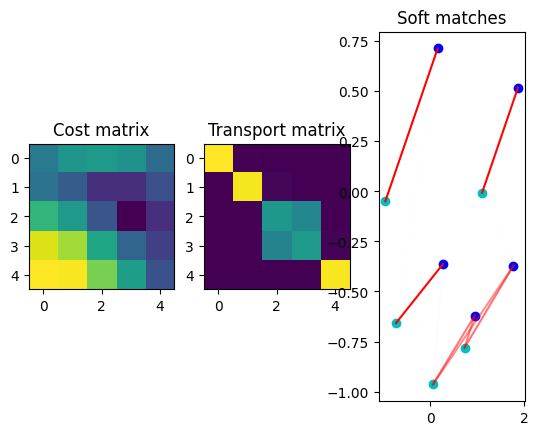

In [255]:


r = np.ones(n) / n
c = np.ones(m) / m

M = distance_matrix(X1, X2)

P, d = compute_optimal_transport(M, r, c, lam=30, epsilon=1e-5)
print(P)
fig, (ax1, ax2, ax) = plt.subplots(ncols=3)
ax.scatter(X1[:,0], X1[:,1], color='b')
ax.scatter(X2[:,0], X2[:,1], color='c')

## ORIGINAl: all soft matches plotted
for i in range(n):
    for j in range(m):
        ax.plot([X1[i,0], X2[j,0]], [X1[i,1], X2[j,1]], color='r',
                alpha=P[i,j] * n)


ax.set_title('Soft matches')

ax1.imshow(M)
ax1.set_title('Cost matrix')

ax2.imshow(P)
ax2.set_title('Transport matrix')
print(d)
plt.show()

Here, we visualize all of the 'soft' matches within the transport matrix. Let's start by taking the maximum value per row in the transport matrix to see what the 'best' match is for every blue point:

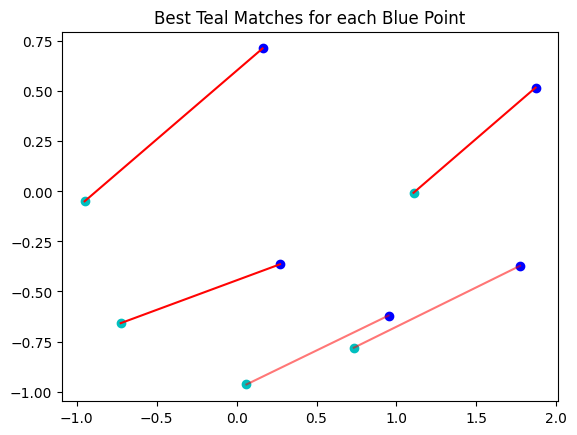

In [256]:
fig, ax = plt.subplots(ncols=1)
ax.scatter(X1[:,0], X1[:,1], color='b')
ax.scatter(X2[:,0], X2[:,1], color='c')

for i in range(n):
    P_i = P[i]
    j = np.argmax(P_i)
    ax.plot([X1[i,0], X2[j,0]], [X1[i,1], X2[j,1]], color='r', alpha=P[i,j]*n)

ax.set_title('Best Teal Matches for each Blue Point')

plt.show()


There are two issues here. First, multiple blue points can map to the same teal point. Further, not all teal points are matched.

How would we ensure that a 1:1 mapping can occur, when we have an equal amount of points per colour?

One way to do that is to iteratively choose the highest score, in the transport matrix, create the associated match, and then prevent all future matches from using these two points. Here is that implementation:

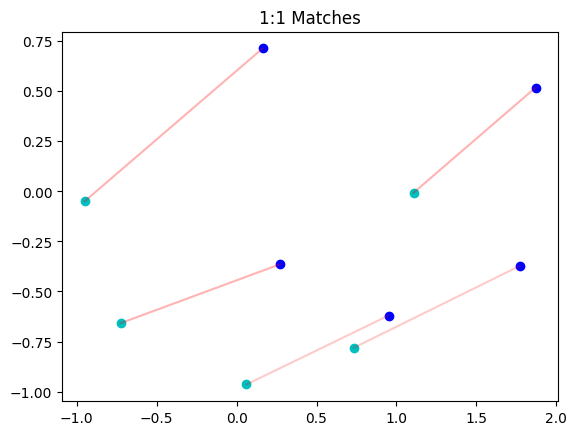

In [257]:
fig, ax = plt.subplots(ncols=1)
ax.scatter(X1[:,0], X1[:,1], color='b')
ax.scatter(X2[:,0], X2[:,1], color='c')

P_copy = np.array(P)
match_idx_x = []
match_idx_y = []

count = 0
while P_copy.sum() > 0:
    count += 1
    max_i_idx = np.argmax(np.max(P_copy,axis=1))
    max_j_idx = np.argmax(P_copy[max_i_idx])

    match_idx_x.append(max_i_idx)
    match_idx_y.append(max_j_idx)

    P_copy[max_i_idx,:] = 0
    P_copy[:,max_j_idx] = 0

for i, j in zip(match_idx_x, match_idx_y):
    ax.plot([X1[i,0], X2[j,0]], [X1[i,1], X2[j,1]], color='r', alpha=0.1+P[i,j])


ax.set_title('1:1 Matches')

plt.show()

As a result, we get a nice 1:1 correspondence, but there is a risk, in that by enforcing all points to match, some of the correspondences will be false. In reality, there may be outliers that shouldn't be matched at all, or the number of Blue and Teal points will be different. How do we account for this case?

The answer is by adding *dustbins* to the cost map. This adds another row and column to the cost map, and is populated by a 'unmatched' cost value (this is a hyperparameter that needs to be tuned or learned).

See the SuperGlue paper for info on the dustbin implementation.

In [258]:

## Add dustbins

unmatched_cost = 2.5

# Add a column and row to M
M_dustbin = np.vstack((M, unmatched_cost*np.ones((1, M.shape[1]))))
M_dustbin = np.hstack((M_dustbin, unmatched_cost*np.ones((M_dustbin.shape[0],1))))

# Update the row/column constraints
# Note that r and c are normalized, so this is equivalent to making r and c as (1,1, ... , 1, n) and (1,1,...1,m)
# I.E., we are allowing all points to be unmatched depending on their matching costs, compared to the unmatched cost value
r_dustbin = np.hstack((r,1))
c_dustbin = np.hstack((c,1))

P, d = compute_optimal_transport(M_dustbin, r_dustbin, c_dustbin, lam=30, epsilon=1e-5)

unmatched_n = 0
for i in range(0, P.shape[0]-1):
    if np.argmax(P[i,:]) == n:
        unmatched_n += 1

unmatched_m = 0
for j in range(0, P.shape[1]-1):
    if np.argmax(P[:,j]) == m:
        unmatched_m += 1

print("unmatched n: {}, unmatched m: {}".format(unmatched_n, unmatched_m))



unmatched n: 0, unmatched m: 0


Now we can determine non-matched points by checking where the maximum value of the transport matrix rows/columns is at the very end. In this case, we can see that there are two unmatched blue points, and three unmatched teal points. Let's plot this:

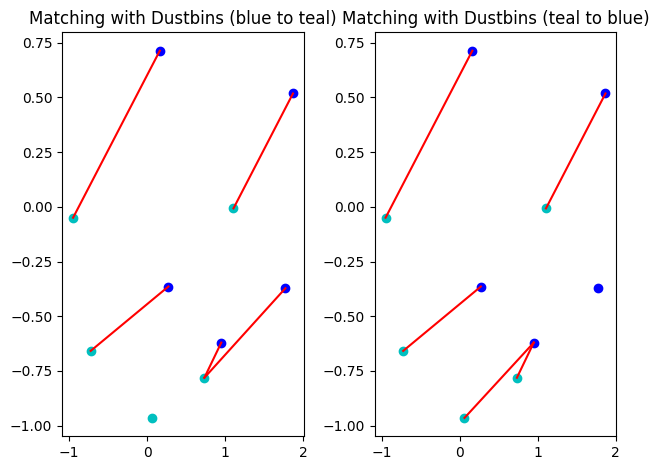

In [259]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.scatter(X1[:,0], X1[:,1], color='b')
ax1.scatter(X2[:,0], X2[:,1], color='c')
ax2.scatter(X1[:,0], X1[:,1], color='b')
ax2.scatter(X2[:,0], X2[:,1], color='c')

unmatch_thresh_m = P[:,-1]
blue_to_teal_matches = []
for i in range(n):
    P_i = P[i,0:-1]
    j = np.argmax(P_i)

    blue_to_teal_matches.append([i,j])
    ax1.plot([X1[i,0], X2[j,0]], [X1[i,1], X2[j,1]], color='r')

    # # Only plot matches (P_ij > P_dustbin)
    # if P_i[j] >= unmatch_thresh_m[i]:
    #     blue_to_teal_matches.append([i,j])
    #     ax1.plot([X1[i,0], X2[j,0]], [X1[i,1], X2[j,1]], color='r', alpha=P[i,j]*n)
    # else:
    #     ax1.scatter([X1[i,0]], [X1[i,1]], marker='x', s=100)

ax1.set_title('Matching with Dustbins (blue to teal)')

unmatch_thresh_n = P[-1,:]

teal_to_blue_matches = []
for j in range(0,m):
    P_j = P[0:-1,j]
    i = np.argmax(P_j)

    teal_to_blue_matches.append([i,j])
    ax2.plot([X1[i,0], X2[j,0]], [X1[i,1], X2[j,1]], color='r')

    # # Only plot matches (P_ij > P_dustbin)
    # if P_j[i] >= unmatch_thresh_n[j]:
    #     teal_to_blue_matches.append([i,j])
    #     ax2.plot([X1[i,0], X2[j,0]], [X1[i,1], X2[j,1]], color='r', alpha=P[i,j]*n)
    # else:
    #     ax2.scatter([X2[j,0]], [X2[j,1]], marker='x', s=100)

ax2.set_title('Matching with Dustbins (teal to blue)')
fig.tight_layout()
plt.show()

Note that matches from blue to teal are different than matches from teal to blue. Let's plot only the dual matches:

[[0, 0], [1, 1], [2, 3], [4, 4]]


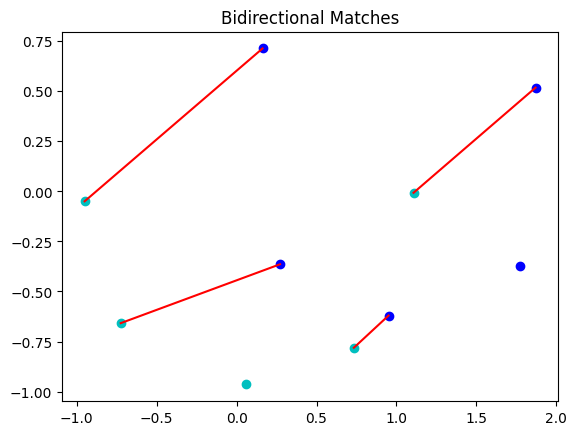

In [260]:
bidirectional_matches = []

for mx in teal_to_blue_matches:
  if mx in blue_to_teal_matches:
    bidirectional_matches.append(mx)

print(bidirectional_matches)

fig, ax = plt.subplots(ncols=1)
ax.scatter(X1[:,0], X1[:,1], color='b')
ax.scatter(X2[:,0], X2[:,1], color='c')

for mx in bidirectional_matches:
    i,j = mx[0], mx[1]
    ax.plot([X1[i,0], X2[j,0]], [X1[i,1], X2[j,1]], color='r')

ax.set_title('Bidirectional Matches')

plt.show()



We don't get all of the points, but we get a nice set of inliers. Note that this doesn't guarantee 1:1 matching still.

Let's compare this to the SuperGlue algorithm in PyTorch.

tensor([[[1.9862e-01, 1.9189e-03, 1.3532e-09, 2.5641e-17, 1.0357e-16,
          1.3805e-13],
         [3.3339e-06, 1.3121e-01, 6.8727e-02, 1.7466e-10, 5.7035e-19,
          1.7067e-19],
         [2.1543e-11, 1.1199e-05, 8.5312e-02, 1.1461e-01, 3.7737e-11,
          2.8969e-15],
         [2.3432e-10, 1.0812e-05, 4.5959e-02, 8.5387e-02, 6.8341e-02,
          2.3823e-04],
         [1.1927e-09, 1.3571e-07, 1.7930e-06, 2.8820e-07, 1.3166e-01,
          6.8275e-02],
         [1.3760e-03, 6.6844e-02, 1.9564e-07, 3.2652e-16, 5.7013e-21,
          9.3149e-01]]], dtype=torch.float64)


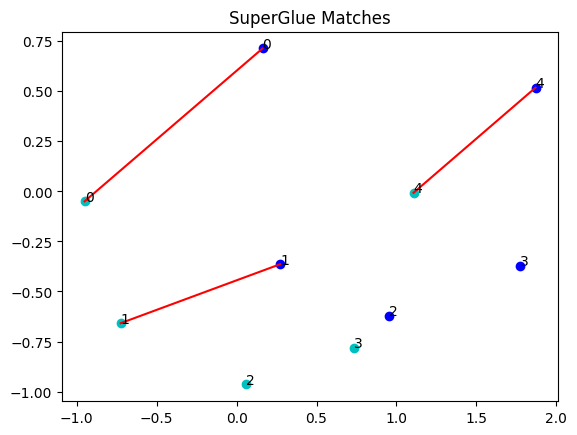

In [261]:
import torch

def arange_like(x, dim: int):
    return x.new_ones(x.shape[dim]).cumsum(0) - 1  # traceable in 1.1

# scores is P, in a batch.
scores = torch.from_numpy(P).unsqueeze(0)
print(scores)
match_threshold = 0.0

# Get the matches with score above "match_threshold".
max0, max1 = scores[:, :-1, :-1].max(2), scores[:, :-1, :-1].max(1) # max0 are column max, and max1 are row max, and contain the values (max.values) and indices (max.indices)

indices0, indices1 = max0.indices, max1.indices # indices0 and 1 are the locations (row and column) of the max score

mutual0 = arange_like(indices0, 1)[None] == indices1.gather(1, indices0)
mutual1 = arange_like(indices1, 1)[None] == indices0.gather(1, indices1)

zero = scores.new_tensor(0)
mscores0 = torch.where(mutual0, max0.values, zero)
mscores1 = torch.where(mutual1, mscores0.gather(1, indices1), zero)

# valid0 and valid1 are booleans. Valid are where True, and the score exceeds the threshold
valid0 = mutual0 & (mscores0 > match_threshold)
valid1 = mutual1 & valid0.gather(1, indices1)

# where valid, store the indices, otherwise replace invalid indices with -1
indices0 = torch.where(valid0, indices0, indices0.new_tensor(-1))
indices1 = torch.where(valid1, indices1, indices1.new_tensor(-1))


fig, ax = plt.subplots(ncols=1)
ax.scatter(X1[:,0], X1[:,1], color='b')
ax.scatter(X2[:,0], X2[:,1], color='c')

for (j,i) in zip(indices0[0], indices1[0]):
    if i != -1 and j != -1:
      ax.plot([X1[i,0], X2[j,0]], [X1[i,1], X2[j,1]], color='r')

for count in range(0,n):
  ax.annotate(count, (X1[count,0], X1[count,1]))
for count in range(0,m):
  ax.annotate(count, (X2[count,0], X2[count,1]))

ax.set_title('SuperGlue Matches')

plt.show()

Let's try the same thing now with image feature matching.

In [267]:

# Important NOTE:  Use opencv >=4.4
import cv2

# Loading the image
img1 = cv2.imread('img1.jpg')

 # Converting image to grayscale
gray1= cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)

# Applying SIFT detector
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None)

# Loading the image
img2 = cv2.imread('img2.jpg')

 # Converting image to grayscale
gray2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
kp2, des2 = sift.detectAndCompute(gray2, None)

x1 = []
y1 = []
for point in kp1:
  x1.append(point.pt[0])
  y1.append(point.pt[1])

x2 = []
y2 = []
for point in kp2:
  x2.append(point.pt[0])
  y2.append(point.pt[1])

X1 = np.array([x1, y1]).T
X2 = np.array([x2, y2]).T

n = X1.shape[0]
m = X2.shape[0]

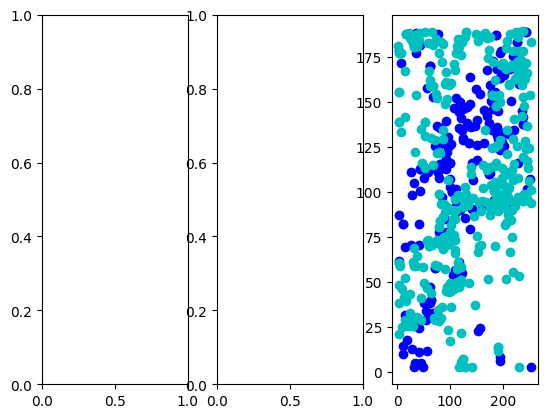

In [268]:
r = np.ones(n) / n
c = np.ones(m) / m


M = distance_matrix(des1, des2)
M/=np.max(M)

P, d = compute_optimal_transport(M, r, c, lam=30, epsilon=1e-5)

fig, (ax1, ax2, ax) = plt.subplots(ncols=3)
ax.scatter(X1[:,0], X1[:,1], color='b')
ax.scatter(X2[:,0], X2[:,1], color='c')

# ## ORIGINAl: all soft matches plotted
# for i in range(n):
#     for j in range(m):
#         ax.plot([X1[i,0], X2[j,0]], [X1[i,1], X2[j,1]], color='r',
#                 alpha=P[i,j] * n)


# ax.set_title('Soft matches')

# ax1.imshow(M)
# ax1.set_title('Cost matrix')

# ax2.imshow(P)
# ax2.set_title('Transport matrix')
# print(d)
# plt.show()

(192, 256, 3) (192, 256, 3)


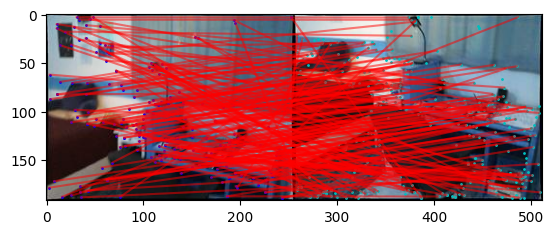

In [269]:
fig, ax = plt.subplots(ncols=1)
ax.scatter(X1[:,0], X1[:,1], color='b',s=1)
ax.scatter(X2[:,0]+256, X2[:,1], color='c',s=1)

P_copy = np.array(P)
match_idx_x = []
match_idx_y = []

count = 0
good = []
while count < 200:
    count += 1
    max_i_idx = np.argmax(np.max(P_copy,axis=1))
    max_j_idx = np.argmax(P_copy[max_i_idx])

    match_idx_x.append(max_i_idx)
    match_idx_y.append(max_j_idx)

    P_copy[max_i_idx,:] = 0
    P_copy[:,max_j_idx] = 0

for i, j in zip(match_idx_x, match_idx_y):
    ax.plot([X1[i,0], X2[j,0]+256], [X1[i,1], X2[j,1]], color='r', alpha=0.5)


# ax.set_title('1:1 Matches')

# plt.show()

ax

print(img1.shape, img2.shape)
img_comb = np.hstack((img1, img2))
plt.imshow(img_comb)

# bf = cv2.BFMatcher()
# matches = bf.knnMatch(des1,des2,k=2)
# # Apply ratio test
# good = []
# for m,n in matches:
#     if m.distance < 0.75*n.distance:
#         good.append([m])

# img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
# plt.imshow(img3),plt.show()

Optimal transport does a decent job matching the image features. Let's see the SuperGlue matching:

(206, 352)


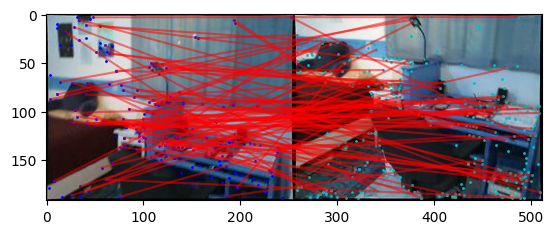

In [270]:
unmatched_cost = 0.9

max_len = max(n,m)
M_crop = M[0:max_len,0:max_len]
r_crop = r[0:max_len]
c_crop = c[0:max_len]

# Add a column and row to M
M_dustbin = np.vstack((M_crop, unmatched_cost*np.ones((1, M_crop.shape[1]))))
M_dustbin = np.hstack((M_dustbin, unmatched_cost*np.ones((M_dustbin.shape[0],1))))

# Update the row/column constraints
# Note that r and c are normalized, so this is equivalent to making r and c as (1,1, ... , 1, n) and (1,1,...1,m)
# I.E., we are allowing all points to be unmatched depending on their matching costs, compared to the unmatched cost value
r_dustbin = np.hstack((r_crop,1))
c_dustbin = np.hstack((c_crop,1))

P, d = compute_optimal_transport(M_dustbin, r_dustbin, c_dustbin, lam=30, epsilon=1e-5)

print(P.shape)

# scores is P, in a batch.
scores = torch.from_numpy(P).unsqueeze(0)
match_threshold = 0.0

# Get the matches with score above "match_threshold".
max0, max1 = scores[:, :-1, :-1].max(2), scores[:, :-1, :-1].max(1) # max0 are column max, and max1 are row max, and contain the values (max.values) and indices (max.indices)

indices0, indices1 = max0.indices, max1.indices # indices0 and 1 are the locations (row and column) of the max score

mutual0 = arange_like(indices0, 1)[None] == indices1.gather(1, indices0)
mutual1 = arange_like(indices1, 1)[None] == indices0.gather(1, indices1)

zero = scores.new_tensor(0)
mscores0 = torch.where(mutual0, max0.values, zero)
mscores1 = torch.where(mutual1, mscores0.gather(1, indices1), zero)

# valid0 and valid1 are booleans. Valid are where True, and the score exceeds the threshold
valid0 = mutual0 & (mscores0 > match_threshold)
valid1 = mutual1 & valid0.gather(1, indices1)

# where valid, store the indices, otherwise replace invalid indices with -1
indices0 = torch.where(valid0, indices0, indices0.new_tensor(-1))
indices1 = torch.where(valid1, indices1, indices1.new_tensor(-1))

fig, ax = plt.subplots(ncols=1)

plt.imshow(img_comb)

ax.scatter(X1[:,0], X1[:,1], color='b',s=1)
ax.scatter(X2[:,0]+256, X2[:,1], color='c',s=1)

for j,i in zip(indices0[0], indices1[0]):
    if i != -1 and j != -1:
      ax.plot([X1[i,0], X2[j,0]+256], [X1[i,1], X2[j,1]], color='r', alpha=0.5)







Something is wrong with this implementation - the explicit 1:1 matching is much better. It may be due to having unequal points per image